In [1]:
# !!! Caution remember to run the correction script !!!!!

{'As': 2.319164838844771e-09, 'ns': 0.9551102751801642, 'Omb': 0.05717195839822765, 'Omm': 0.35157888464949827, 'h': 0.6213012817465179, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
Nonlinear P(k) at z = 5: [1463.1023 1100.2347  806.1626  677.5412  504.7412]
Nonlinear P(k) at z = 0: [33595.543 25899.582 19454.383 16309.91  12847.416]
{'As': 2.319164838844771e-09, 'ns': 0.9551102751801642, 'Omb': 0.05717195839822765, 'Omm': 0.35157888464949827, 'h': 0.6213012817465179, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
Averaged nonlinear P(k) shape: (100, 27)
P(k, z=5): [1463.1024  1100.2345   806.16266  677.5411   504.74118]
P(k, z=0): [2594.0989 1954.209  1434.8807 1205.2218  899.6486]


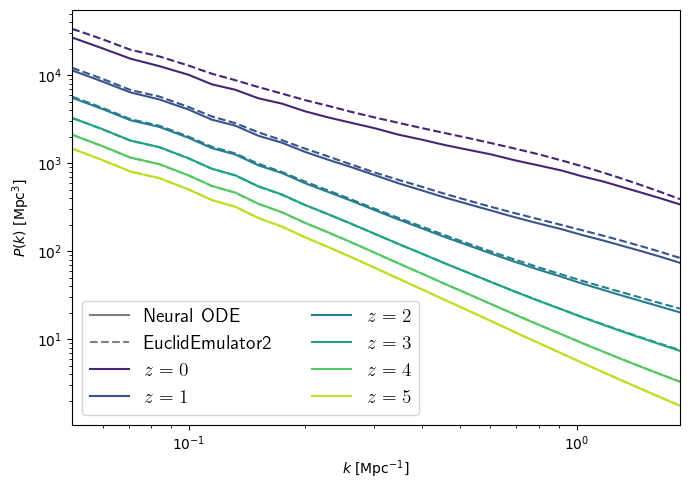

In [ ]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
from matplotlib import pyplot as plt

for seed in [42]:

    # --- Initialize emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")

    # --- Load k-grid ---
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
    k = k_full[k_idx]
    


    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)


    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    mnu = 0.0
    w = -1.0
    wa = 0.0

    k_h_units = k / h


    cosmo_dict = {
        'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
        'mnu': mnu, 'w': w, 'wa': wa,
    }

    print(cosmo_dict)

    # --- Setup emulator inputs ---
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)



    def get_nonlinear_pk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k_h_units)
        pk_nl = pk_lin * boost[0]
        return pk_nl

    # --- Compute nonlinear P(k) ---
    pk_nl_z5 = get_nonlinear_pk(5.0)
    pk_nl_z0 = get_nonlinear_pk(0.0)

    # --- Print example values ---
    print("Nonlinear P(k) at z = 5:", pk_nl_z5[:5])
    print("Nonlinear P(k) at z = 0:", pk_nl_z0[:5])


    import jax
    import jax.numpy as jnp
    import numpy as np
    import equinox as eqx
    from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
    import os
    from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
    import euclidemu2 as ee2

    # --- Load k and emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
    k = k_full[k_idx]
    k_shp = np.shape(k_idx)[0]

    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)
    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)

    cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
    print(cosmo_dict)
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)

    # --- Get nonlinear logP(k,z) ---
    def get_nl_logpk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k_h_units)
        pk_nl = pk_lin * boost[0]
        return jnp.log(pk_nl.astype(jnp.float32))

    # --- Background quantities ---
    G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

    def Hz_func(z):
        a = 1.0 / (1.0 + z)
        Ez2 = Omm * (1 + z)**3 + (1 - Omm) * a**(-3 * (1 + (-1.0)))
        return 100.0 * h * jnp.sqrt(Ez2)

    def rho_m_func(z):
        rho_crit = 3 * (100.0 * h)**2. / (8 * jnp.pi * G)
        return Omm * rho_crit * (1+z) ** 3.

    # --- Load normalization ---
    data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
    norm_data = np.load(os.path.join(data_dir, "logpk_data.npz"))
    Hz_all = norm_data["Hz"]
    rho_m_all = norm_data["rho_m"]

    H_mean, H_std = Hz_all.mean(), Hz_all.std()
    log_rho_all = np.log10(rho_m_all + 1e-30)
    log_rho_mean, log_rho_std = log_rho_all.mean(), log_rho_all.std()

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

    # --- Define model class ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, rho, z):
            x = jnp.concatenate([P, H, rho, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- ODE RHS ---
    def rhs(z, logP, args):
        model, = args
        H_z = jnp.atleast_1d(H_norm(z))
        rho_z = jnp.atleast_1d(rho_norm(z))
        return model(logP, H_z, rho_z, z)

    # --- Initial condition and time range ---
    z0 = 5.0
    z1 = 0.0
    ts = jnp.linspace(z0, z1, 100)
    logpk0 = get_nl_logpk(z0)

    # --- Solve with all 10 models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
    all_pk = []

    for i in range(10):
        model_path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
        model = RHS()
        model_params = eqx.tree_deserialise_leaves(model_path, model)
        model = eqx.combine(model_params, model)

        term = ODETerm(rhs)
        solver = Tsit5()
        saveat = SaveAt(ts=ts)

        sol = diffeqsolve(
            term,
            solver,
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model,),
            saveat=saveat
        )
        logpk_sol = sol.ys
        all_pk.append(jnp.exp(logpk_sol))

    # --- Average prediction over models ---
    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

    print(f"Averaged nonlinear P(k) shape: {pk_mean.shape}")
    print(f"P(k, z=5): {pk_mean[0, :5]}")
    print(f"P(k, z=0): {pk_mean[30, :5]}")




    # Redshifts to plot
    z_list = [0, 1, 2, 3, 4, 5]
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(z_list)))

    plt.figure(figsize=(7, 5))

    # Plot all redshifts
    from matplotlib.lines import Line2D
    for i, z in enumerate(z_list):
        z_idx = int(jnp.argmin(jnp.abs(ts - z)))
        pk_pred = pk_mean[z_idx]
        pk_true = get_nonlinear_pk(z)

        # Plot Neural ODE prediction (solid)
        plt.plot(k, pk_pred, color=colors[i], ls='-')

        # Plot EuclidEmulator2 (dashed)
        plt.plot(k, pk_true, color=colors[i], ls='--')

    # Axes settings
    import matplotlib as mpl
    from matplotlib import rcParams

    plt.rc('text', usetex=True)

    # Set global font sizes
    rcParams.update({
        "legend.fontsize": 18,         # Legend text
        "axes.labelsize": 24,          # Axis labels
        "xtick.labelsize": 18,         # X-axis tick labels
        "ytick.labelsize": 18          # Y-axis tick labels
    })
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$k\ [\mathrm{Mpc}^{-1}]$")
    plt.ylabel(r"$P(k)\ [\mathrm{Mpc}^3]$")
    plt.xlim(k.min(), k.max())
    #plt.ylim(5e1, 3e5)

    # Custom legend
    style_handles = [
        Line2D([0], [0], color='gray', ls='-', label='Neural ODE'),
        Line2D([0], [0], color='gray', ls='--', label='EuclidEmulator2')
    ]
    color_handles = [
        Line2D([0], [0], color=colors[i], ls='-', label=fr'$z={z}$')
        for i, z in enumerate(z_list)
    ]
    handles = style_handles + color_handles
    plt.legend(handles=handles, fontsize=14, ncol=2, loc='lower left')

    plt.tight_layout()
    plt.plot()
    plt.savefig('plots/pk.pdf')





(27,)
{'As': 2.2095693498571633e-09, 'ns': 0.9415829371011096, 'Omb': 0.0408194704787239, 'Omm': 0.24264442168456465, 'h': 0.7075924287040327, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
Nonlinear P(k) at z = 5: [1356.8916   979.584    727.87854  611.9493   430.06738]
Nonlinear P(k) at z = 0: [26696.604 19798.918 15146.575 12432.258  9544.313]
{'As': 2.2095693498571633e-09, 'ns': 0.9415829371011096, 'Omb': 0.0408194704787239, 'Omm': 0.24264442168456465, 'h': 0.7075924287040327, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
Averaged nonlinear P(k) shape: (100, 27)
P(k, z=5): [1356.8915   979.5839   727.8785   611.9493   430.06744]
P(k, z=0): [2412.7556 1743.4543 1297.4232 1089.9037  768.9756]
(27,)
{'As': 2.1094572997602056e-09, 'ns': 0.9960370957060748, 'Omb': 0.042883192254392674, 'Omm': 0.391783911541959, 'h': 0.6474197742412582, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
Nonlinear P(k) at z = 5: [1509.2828  1221.3369   953.6186   791.69904  622.9691 ]
Nonlinear P(k) at z = 0: [35363.043 28902.436 23005.045 19119.

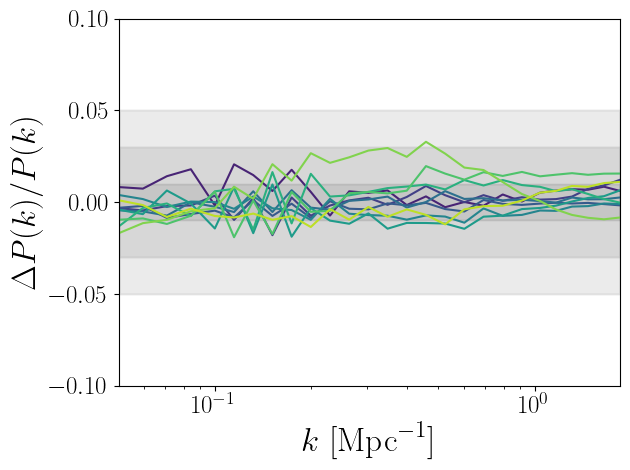

In [7]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
from matplotlib import pyplot as plt
# Axes settings
import matplotlib as mpl
from matplotlib import rcParams

plt.rc('text', usetex=True)

# Set global font sizes
rcParams.update({
    "legend.fontsize": 18,         # Legend text
    "axes.labelsize": 24,          # Axis labels
    "xtick.labelsize": 18,         # X-axis tick labels
    "ytick.labelsize": 18          # Y-axis tick labels
})

for j in range(10):
    seed = j  # Ensure different seeds for each run

    # --- Initialize emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")

    # --- Load k-grid ---
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
    k = k_full[k_idx]
    print (np.shape(k_idx))


    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)


    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    mnu = 0.0
    w = -1.0
    wa = 0.0

    k_h_units = k / h

    cosmo_dict = {
        'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
        'mnu': mnu, 'w': w, 'wa': wa,
    }

    print(cosmo_dict)

    # --- Setup emulator inputs ---
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)



    def get_nonlinear_pk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k_h_units)
        pk_nl = pk_lin * boost[0]
        return pk_nl

    # --- Compute nonlinear P(k) ---
    pk_nl_z5 = get_nonlinear_pk(5.0)
    pk_nl_z0 = get_nonlinear_pk(0.0)

    # --- Print example values ---
    print("Nonlinear P(k) at z = 5:", pk_nl_z5[:5])
    print("Nonlinear P(k) at z = 0:", pk_nl_z0[:5])


    import jax
    import jax.numpy as jnp
    import numpy as np
    import equinox as eqx
    from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
    import os
    from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
    import euclidemu2 as ee2

    # --- Load k and emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
    k = k_full[k_idx]
    k_shp = np.shape(k_idx)[0]

    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)
    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)

    cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
    print(cosmo_dict)
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)

    # --- Get nonlinear logP(k,z) ---
    def get_nl_logpk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k_h_units)
        pk_nl = pk_lin * boost[0]
        return jnp.log(pk_nl.astype(jnp.float32))

    # --- Background quantities ---
    G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

    def Hz_func(z):
        a = 1.0 / (1.0 + z)
        Ez2 = Omm * (1 + z)**3 + (1 - Omm) * a**(-3 * (1 + (-1.0)))
        return 100.0 * h * jnp.sqrt(Ez2)

    def rho_m_func(z):
        Hz = Hz_func(z)
        rho_crit = 3 * Hz**2 / (8 * jnp.pi * G)
        return Omm * rho_crit

    # --- Load normalization ---
    data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
    norm_data = np.load(os.path.join(data_dir, "logpk_data.npz"))
    Hz_all = norm_data["Hz"]
    rho_m_all = norm_data["rho_m"]

    H_mean, H_std = Hz_all.mean(), Hz_all.std()
    log_rho_all = np.log10(rho_m_all + 1e-30)
    log_rho_mean, log_rho_std = log_rho_all.mean(), log_rho_all.std()

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

    # --- Define model class ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, rho, z):
            x = jnp.concatenate([P, H, rho, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- ODE RHS ---
    def rhs(z, logP, args):
        model, = args
        H_z = jnp.atleast_1d(H_norm(z))
        rho_z = jnp.atleast_1d(rho_norm(z))
        return model(logP, H_z, rho_z, z)

    # --- Initial condition and time range ---
    z0 = 5.0
    z1 = 0.0
    ts = jnp.linspace(z0, z1, 100)
    logpk0 = get_nl_logpk(z0)

    # --- Solve with all 10 models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
    all_pk = []

    for i in range(10):
        model_path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
        model = RHS()
        model_params = eqx.tree_deserialise_leaves(model_path, model)
        model = eqx.combine(model_params, model)

        term = ODETerm(rhs)
        solver = Tsit5()
        saveat = SaveAt(ts=ts)

        sol = diffeqsolve(
            term,
            solver,
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model,),
            saveat=saveat
        )
        logpk_sol = sol.ys
        all_pk.append(jnp.exp(logpk_sol))

    # --- Average prediction over models ---
    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

    print(f"Averaged nonlinear P(k) shape: {pk_mean.shape}")
    print(f"P(k, z=5): {pk_mean[0, :5]}")
    print(f"P(k, z=0): {pk_mean[30, :5]}")

    colors = plt.cm.viridis(np.linspace(0.1, 0.9, 10))

    residual = (pk_mean[-1] - pk_nl_z0) / pk_nl_z0
    plt.plot(k, residual, color = colors[j])
    plt.xscale('log')
    plt.xlabel(r"$k\ [\mathrm{Mpc}^{-1}]$")
    plt.ylabel(r"$\Delta P(k) / P(k)$")

    #plt.axhspan(-0.02, 0.02, color='gray', alpha=0.3, zorder=0)
    plt.axhspan(-0.05, 0.05, color='gray', alpha=0.01, zorder=0)
    plt.axhspan(-0.03, 0.03, color='gray', alpha=0.01, zorder=0)
    plt.axhspan(-0.01, 0.01, color='gray', alpha=0.02, zorder=0)
    #plt.axhspan(-0.01, 0.01, color='gray', alpha=0.3, zorder=0)


    # --- Set shared x-limits ---
    plt.xlim(k.min(), k.max())
    plt.ylim(-0.1,0.1)

plt.tight_layout()
plt.savefig('plots/error.pdf')

    

(27,)
{'As': 2.1094572997602056e-09, 'ns': 0.9960370957060748, 'Omb': 0.042883192254392674, 'Omm': 0.391783911541959, 'h': 0.6474197742412582, 'mnu': 0.0, 'w': -0.8, 'wa': -0.6}
Nonlinear P(k) at z = 5: [1511.371   1223.4316   955.1746   792.44916  624.00214]
Nonlinear P(k) at z = 0: [34954.992 28604.525 22746.643 18770.543 15115.685]
Averaged nonlinear P(k) shape: (100, 27)
P(k, z=5): [1511.3712  1223.4316   955.17474  792.4492   624.00214]
P(k, z=0): [2692.778  2181.9302 1704.849  1414.7709 1115.149 ]


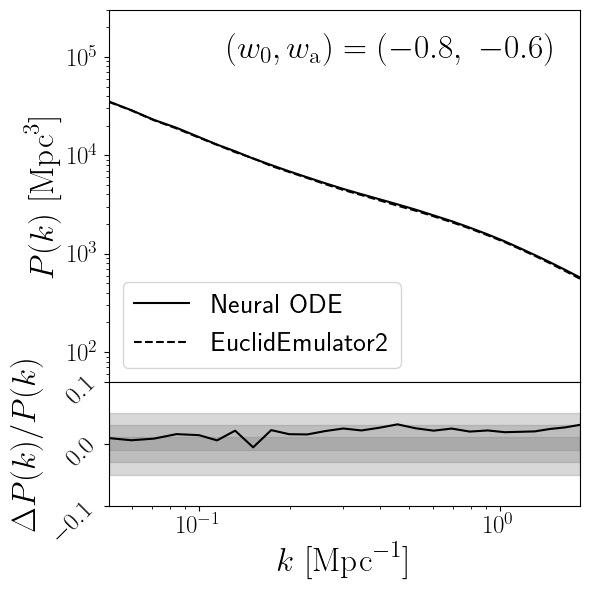

In [27]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
from matplotlib import pyplot as plt

for seed in [1]:

    # --- Initialize emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")

    # --- Load k-grid ---
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
    k = k_full[k_idx]
    print (np.shape(k_idx))


    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)


    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    mnu = 0.0
    w = -0.8
    wa = -0.6

    k_h_units = k / h

    cosmo_dict = {
        'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
        'mnu': mnu, 'w': w, 'wa': wa,
    }

    print(cosmo_dict)

    # --- Setup emulator inputs ---
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)


    def get_camb_pk_ratio(z, k_h_units, cosmo_dict):
        from camb import CAMBparams, get_results

        def get_pk_camb(z, w, wa):
            pars = CAMBparams()
            pars.set_cosmology(
                H0=cosmo_dict['h'] * 100,
                ombh2=cosmo_dict['Omb'] * cosmo_dict['h']**2,
                omch2=(cosmo_dict['Omm'] - cosmo_dict['Omb']) * cosmo_dict['h']**2,
                mnu=cosmo_dict['mnu']
            )
            pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf')
            pars.InitPower.set_params(As=cosmo_dict['As'], ns=cosmo_dict['ns'])
            pars.set_matter_power(redshifts=[z], kmax=k_h_units.max())
            results = get_results(pars)
            PK = results.get_matter_power_interpolator(nonlinear=False, hubble_units=True, k_hunit=True)
            return PK.P(z, k_h_units)


        # P(k, z) with w and wa from input
        pk_de = get_pk_camb(z, cosmo_dict['w'], cosmo_dict['wa'])

        # P(k, z) with vanilla ΛCDM
        pk_lcdm = get_pk_camb(z, w=-1.0, wa=0.0)

        return pk_de / pk_lcdm
    
    camb_ratio_0 = get_camb_pk_ratio(0.0, k_h_units, cosmo_dict)
    camb_ratio_5 = get_camb_pk_ratio(5.0, k_h_units, cosmo_dict)


    def get_nonlinear_pk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k_h_units)
        pk_nl = pk_lin * boost[0] * get_camb_pk_ratio(z, k_h_units, cosmo_dict)
        return pk_nl

    # --- Compute nonlinear P(k) ---
    pk_nl_z5 = get_nonlinear_pk(5.0)
    pk_nl_z0 = get_nonlinear_pk(0.0)

    # --- Print example values ---
    print("Nonlinear P(k) at z = 5:", pk_nl_z5[:5])
    print("Nonlinear P(k) at z = 0:", pk_nl_z0[:5])


    import jax
    import jax.numpy as jnp
    import numpy as np
    import equinox as eqx
    from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
    import os
    from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
    import euclidemu2 as ee2

    # --- Load k and emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
    k = k_full[k_idx]
    k_shp = np.shape(k_idx)[0]

    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)
    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)

    cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': w, 'wa': wa}
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)

    # --- Get nonlinear logP(k,z) ---
    def get_nl_logpk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k_h_units)
        pk_nl = pk_lin * boost[0]* get_camb_pk_ratio(z, k_h_units, cosmo_dict)
        return jnp.log(pk_nl.astype(jnp.float32))

    # --- Background quantities ---
    G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

    def Hz_func(z):
        a = 1.0 / (1.0 + z)
        w_z = w + wa * z / (1 + z)
        de_factor = a**(-3 * (1 + w + wa)) * jnp.exp(-3 * wa * z / (1 + z))
        Ez2 = Omm * (1 + z)**3 + (1 - Omm) * de_factor
        return 100.0 * h * jnp.sqrt(Ez2)

    def rho_m_func(z):
        Hz = Hz_func(z)
        rho_crit = 3 * Hz**2 / (8 * jnp.pi * G)
        return Omm * rho_crit

    # --- Load normalization ---
    data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
    norm_data = np.load(os.path.join(data_dir, "logpk_data.npz"))
    Hz_all = norm_data["Hz"]
    rho_m_all = norm_data["rho_m"]

    H_mean, H_std = Hz_all.mean(), Hz_all.std()
    log_rho_all = np.log10(rho_m_all + 1e-30)
    log_rho_mean, log_rho_std = log_rho_all.mean(), log_rho_all.std()

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

    # --- Define model class ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, rho, z):
            x = jnp.concatenate([P, H, rho, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- ODE RHS ---
    def rhs(z, logP, args):
        model, = args
        H_z = jnp.atleast_1d(H_norm(z))
        rho_z = jnp.atleast_1d(rho_norm(z))
        return model(logP, H_z, rho_z, z)

    # --- Initial condition and time range ---
    z0 = 5.0
    z1 = 0.0
    ts = jnp.linspace(z0, z1, 100)
    logpk0 = get_nl_logpk(z0)

    # --- Solve with all 10 models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
    all_pk = []

    for i in range(10):
        model_path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
        model = RHS()
        model_params = eqx.tree_deserialise_leaves(model_path, model)
        model = eqx.combine(model_params, model)

        term = ODETerm(rhs)
        solver = Tsit5()
        saveat = SaveAt(ts=ts)

        sol = diffeqsolve(
            term,
            solver,
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model,),
            saveat=saveat
        )
        logpk_sol = sol.ys
        all_pk.append(jnp.exp(logpk_sol))

    # --- Average prediction over models ---
    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

    print(f"Averaged nonlinear P(k) shape: {pk_mean.shape}")
    print(f"P(k, z=5): {pk_mean[0, :5]}")
    print(f"P(k, z=0): {pk_mean[30, :5]}")





    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib import rcParams

    # Enable LaTeX and set fonts
    plt.rc('text', usetex=True)
    rcParams.update({
        "legend.fontsize": 20,
        "axes.labelsize": 24,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18
    })

    # Create subplots with zero vertical space
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(6, 6), sharex=True,
        gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.0}  # hspace = 0 to eliminate vertical gap
    )

    #fig.suptitle(r"$(w_{\rm 0}, w_{\rm a}) = (-0.8,\ -0.6)$", fontsize=24)
    # --- Top panel: P(k) ---
    ax1.plot(k, pk_mean[-1], color='k', ls='-', label='Neural ODE')
    ax1.plot(k, pk_nl_z0, color='k', ls='--', label='EuclidEmulator2')

    # Add (w0, wa) text as legend entry
    ax1.plot([], [])


    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel(r"$P(k)\ [\mathrm{Mpc}^3]$")
    ax1.set_ylim(5e1, 3e5)
    ax1.legend(loc = 'lower left')

    ax1.text(
    #0.02, 0.05,  # x, y in axes fraction (0 = left/bottom, 1 = right/top)
    0.25, 0.85,  # x, y in axes fraction (0 = left/bottom, 1 = right/top)
    r"$(w_{\rm 0}, w_{\rm a}) = (-0.8,\ -0.6)$",
    transform=ax1.transAxes,
    fontsize=24,
    verticalalignment='bottom'
)

    # --- Bottom panel: Residuals ---
    residual = (pk_mean[-1] - pk_nl_z0) / pk_nl_z0
    ax2.plot(k, residual, color='k')
    ax2.set_xscale('log')
    ax2.set_xlabel(r"$k\ [\mathrm{Mpc}^{-1}]$")
    ax2.set_ylabel(r"$\Delta P(k) / P(k)$")
    ax2.set_ylim(-0.1, 0.1)
    ax2.axhspan(-0.05, 0.05, color='gray', alpha=0.3, zorder=0)
    ax2.axhspan(-0.03, 0.03, color='gray', alpha=0.3, zorder=0)
    ax2.axhspan(-0.01, 0.01, color='gray', alpha=0.3, zorder=0)

    # Rotate tick labels on bottom plot
    for label in ax2.get_yticklabels():
        label.set_rotation(45)

    # Shared x-limits
    ax2.set_xlim(k.min(), k.max())

    #fig.title(r"$(w_{\rm 0}, w_{\rm a}) = (-0.8,\ 0.6)$", fontsize=24)
    plt.tight_layout()
    plt.savefig('plots/pk_w1.pdf')





(27,)
{'As': 2.1094572997602056e-09, 'ns': 0.9960370957060748, 'Omb': 0.042883192254392674, 'Omm': 0.391783911541959, 'h': 0.6474197742412582, 'mnu': 0.0, 'w': -0.8, 'wa': -0.0}
[0.90563868 0.90563892 0.90563977 0.90563678 0.90563202 0.90563415
 0.90563309 0.90563163 0.90563309 0.90563277 0.90563293 0.90563338
 0.9056331  0.90563315 0.90562977 0.9056816  0.90555188 0.90565754
 0.90563657 0.90562691 0.90563447 0.90563302 0.90563233 0.90563307
 0.90563307 0.90563274 0.90563274]
[0.99306748 0.99306995 0.99307246 0.99307033 0.99306588 0.9930688
 0.99306805 0.99306672 0.99306839 0.99306848 0.99306881 0.99306921
 0.99306906 0.99306913 0.99306578 0.99312209 0.99298071 0.9930962
 0.99307316 0.99306255 0.99307089 0.99306936 0.9930684  0.99306904
 0.99306919 0.993069   0.99306896]
Nonlinear P(k) at z = 5: [1498.8949  1213.0112   947.00757  786.1712   618.7052 ]
Nonlinear P(k) at z = 0: [32201.14  26293.719 20868.08  17338.547 13867.065]
{'As': 2.1094572997602056e-09, 'ns': 0.9960370957060748, 'O

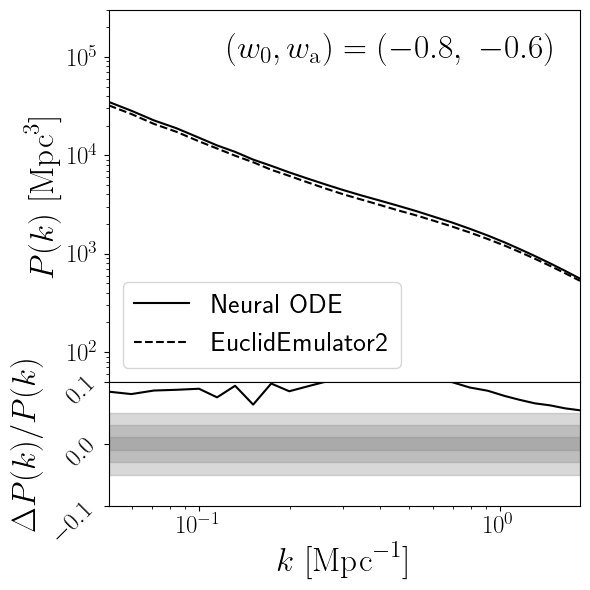

In [2]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
from matplotlib import pyplot as plt

for seed in [1]:

    # --- Initialize emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")

    # --- Load k-grid ---
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
    k = k_full[k_idx]
    print (np.shape(k_idx))


    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)


    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    mnu = 0.0
    w = -0.8
    wa = -0.0

    k_h_units = k / h

    cosmo_dict = {
        'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
        'mnu': mnu, 'w': w, 'wa': wa,
    }

    print(cosmo_dict)

    # --- Setup emulator inputs ---
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)


    def get_camb_pk_ratio(z, k_h_units, cosmo_dict):
        from camb import CAMBparams, get_results

        def get_pk_camb(z, w, wa):
            pars = CAMBparams()
            pars.set_cosmology(
                H0=cosmo_dict['h'] * 100,
                ombh2=cosmo_dict['Omb'] * cosmo_dict['h']**2,
                omch2=(cosmo_dict['Omm'] - cosmo_dict['Omb']) * cosmo_dict['h']**2,
                mnu=cosmo_dict['mnu']
            )
            pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf')
            pars.InitPower.set_params(As=cosmo_dict['As'], ns=cosmo_dict['ns'])
            pars.set_matter_power(redshifts=[z], kmax=k_h_units.max())
            results = get_results(pars)
            PK = results.get_matter_power_interpolator(nonlinear=False, hubble_units=True, k_hunit=True)
            return PK.P(z, k_h_units)


        # P(k, z) with w and wa from input
        pk_de = get_pk_camb(z, cosmo_dict['w'], cosmo_dict['wa'])

        # P(k, z) with vanilla ΛCDM
        pk_lcdm = get_pk_camb(z, w=-1.0, wa=0.0)

        return pk_de / pk_lcdm
    
    camb_ratio_0 = get_camb_pk_ratio(0.0, k_h_units, cosmo_dict)
    camb_ratio_5 = get_camb_pk_ratio(5.0, k_h_units, cosmo_dict)

    print (camb_ratio_0)
    print (camb_ratio_5)



    def get_nonlinear_pk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k_h_units)
        pk_nl = pk_lin * boost[0] * get_camb_pk_ratio(z, k_h_units, cosmo_dict)
        return pk_nl

    # --- Compute nonlinear P(k) ---
    pk_nl_z5 = get_nonlinear_pk(5.0)
    pk_nl_z0 = get_nonlinear_pk(0.0)

    # --- Print example values ---
    print("Nonlinear P(k) at z = 5:", pk_nl_z5[:5])
    print("Nonlinear P(k) at z = 0:", pk_nl_z0[:5])


    import jax
    import jax.numpy as jnp
    import numpy as np
    import equinox as eqx
    from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
    import os
    from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
    import euclidemu2 as ee2

    # --- Load k and emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 5e-2) & (k_full < 2.))[0][::6]
    k = k_full[k_idx]
    k_shp = np.shape(k_idx)[0]

    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)
    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)

    cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': w, 'wa': wa}
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)

    print (cosmo_dict)
    # --- Get nonlinear logP(k,z) ---
    def get_nl_logpk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k_h_units)
        pk_nl = pk_lin * boost[0]* get_camb_pk_ratio(z, k_h_units, cosmo_dict)
        return jnp.log(pk_nl.astype(jnp.float32))

    # --- Background quantities ---
    G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

    def Hz_func(z):
        a = 1.0 / (1.0 + z)
        w_z = w + wa * z / (1 + z)
        de_factor = a**(-3 * (1 + w + wa)) * jnp.exp(-3 * wa * z / (1 + z))
        Ez2 = Omm * (1 + z)**3 + (1 - Omm) * de_factor
        return 100.0 * h * jnp.sqrt(Ez2)

    def rho_m_func(z):
        Hz = Hz_func(z)
        rho_crit = 3 * Hz**2 / (8 * jnp.pi * G)
        return Omm * rho_crit

    # --- Load normalization ---
    data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
    norm_data = np.load(os.path.join(data_dir, "logpk_data.npz"))
    Hz_all = norm_data["Hz"]
    rho_m_all = norm_data["rho_m"]

    H_mean, H_std = Hz_all.mean(), Hz_all.std()
    log_rho_all = np.log10(rho_m_all + 1e-30)
    log_rho_mean, log_rho_std = log_rho_all.mean(), log_rho_all.std()

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

    # --- Define model class ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, rho, z):
            x = jnp.concatenate([P, H, rho, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- ODE RHS ---
    def rhs(z, logP, args):
        model, = args
        H_z = jnp.atleast_1d(H_norm(z))
        rho_z = jnp.atleast_1d(rho_norm(z))
        return model(logP, H_z, rho_z, z)

    # --- Initial condition and time range ---
    z0 = 5.0
    z1 = 0.0
    ts = jnp.linspace(z0, z1, 100)
    logpk0 = get_nl_logpk(z0)

    # --- Solve with all 10 models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
    all_pk = []

    for i in range(10):
        model_path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
        model = RHS()
        model_params = eqx.tree_deserialise_leaves(model_path, model)
        model = eqx.combine(model_params, model)

        term = ODETerm(rhs)
        solver = Tsit5()
        saveat = SaveAt(ts=ts)

        sol = diffeqsolve(
            term,
            solver,
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model,),
            saveat=saveat
        )
        logpk_sol = sol.ys
        all_pk.append(jnp.exp(logpk_sol))

    # --- Average prediction over models ---
    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

    print(f"Averaged nonlinear P(k) shape: {pk_mean.shape}")
    print(f"P(k, z=5): {pk_mean[0, :5]}")
    print(f"P(k, z=0): {pk_mean[30, :5]}")





    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib import rcParams

    # Enable LaTeX and set fonts
    plt.rc('text', usetex=True)
    rcParams.update({
        "legend.fontsize": 20,
        "axes.labelsize": 24,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18
    })

    # Create subplots with zero vertical space
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(6, 6), sharex=True,
        gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.0}  # hspace = 0 to eliminate vertical gap
    )

    #fig.suptitle(r"$(w_{\rm 0}, w_{\rm a}) = (-0.8,\ -0.6)$", fontsize=24)
    # --- Top panel: P(k) ---
    ax1.plot(k, pk_mean[-1], color='k', ls='-', label='Neural ODE')
    ax1.plot(k, pk_nl_z0, color='k', ls='--', label='EuclidEmulator2')

    # Add (w0, wa) text as legend entry
    ax1.plot([], [])


    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel(r"$P(k)\ [\mathrm{Mpc}^3]$")
    ax1.set_ylim(5e1, 3e5)
    ax1.legend(loc = 'lower left')

    ax1.text(
    #0.02, 0.05,  # x, y in axes fraction (0 = left/bottom, 1 = right/top)
    0.25, 0.85,  # x, y in axes fraction (0 = left/bottom, 1 = right/top)
    r"$(w_{\rm 0}, w_{\rm a}) = (-0.8,\ -0.6)$",
    transform=ax1.transAxes,
    fontsize=24,
    verticalalignment='bottom'
)

    # --- Bottom panel: Residuals ---
    residual = (pk_mean[-1] - pk_nl_z0) / pk_nl_z0
    ax2.plot(k, residual, color='k')
    ax2.set_xscale('log')
    ax2.set_xlabel(r"$k\ [\mathrm{Mpc}^{-1}]$")
    ax2.set_ylabel(r"$\Delta P(k) / P(k)$")
    ax2.set_ylim(-0.1, 0.1)
    ax2.axhspan(-0.05, 0.05, color='gray', alpha=0.3, zorder=0)
    ax2.axhspan(-0.03, 0.03, color='gray', alpha=0.3, zorder=0)
    ax2.axhspan(-0.01, 0.01, color='gray', alpha=0.3, zorder=0)

    # Rotate tick labels on bottom plot
    for label in ax2.get_yticklabels():
        label.set_rotation(45)

    # Shared x-limits
    ax2.set_xlim(k.min(), k.max())

    #fig.title(r"$(w_{\rm 0}, w_{\rm a}) = (-0.8,\ 0.6)$", fontsize=24)
    plt.tight_layout()
    plt.savefig('plots/pk_w_fail.pdf')





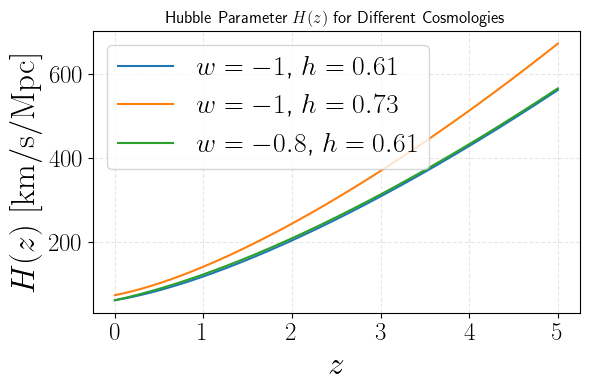

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- H(z) function for constant w ---
def Hz_const_w(z, Omm, h, w):
    a = 1.0 / (1.0 + z)
    Ez2 = Omm * (1 + z)**3 + (1 - Omm) * a**(-3 * (1 + w))
    return 100.0 * h * jnp.sqrt(Ez2)

# --- Redshift grid ---
z_vals = jnp.linspace(0, 5, 300)

# --- Compute H(z) for different cosmologies ---
Hz_1 = Hz_const_w(z_vals, Omm=0.39, h=0.61, w=-1.0)
Hz_2 = Hz_const_w(z_vals, Omm=0.39, h=0.73, w=-1.0)
Hz_3 = Hz_const_w(z_vals, Omm=0.39, h=0.61, w=-0.8)

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.plot(z_vals, Hz_1, label=r"$w=-1$, $h=0.61$")
plt.plot(z_vals, Hz_2, label=r"$w=-1$, $h=0.73$")
plt.plot(z_vals, Hz_3, label=r"$w=-0.8$, $h=0.61$")

plt.xlabel(r"$z$")
plt.ylabel(r"$H(z)\ [\mathrm{km/s/Mpc}]$")
plt.title(r"Hubble Parameter $H(z)$ for Different Cosmologies")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

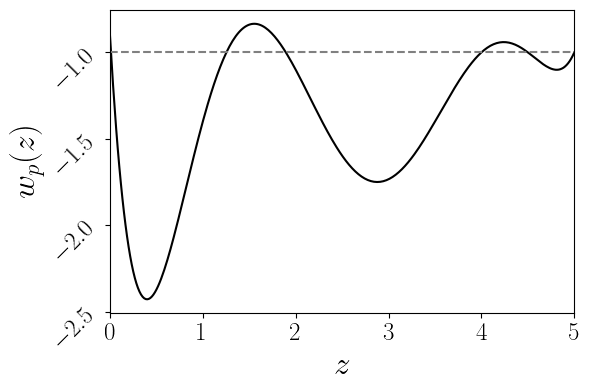

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np  # Still needed for fitting coefficients

# Given w(z) data points
x1 = np.array([0, 1, 2, 3.5, 4.0, 4.5, 5])
y1 = np.array([-0.9, -1.4, -1.1, -1.4, -1.0,-1.0, -1.0])

# Fit degree-4 polynomial (still done with NumPy)
coeffs = np.polyfit(x1, y1, deg=6)
w_coeffs = jnp.array(coeffs)

# Plotting
z_plot = jnp.linspace(0, 5, 300)
w_plot = jnp.polyval(w_coeffs, z_plot)

plt.figure(figsize=(6, 4))
plt.plot(z_plot, w_plot, label=r"$w(z)$", color='k')
plt.axhline(y=-1, color='gray', ls='--', label=r"$w=-1$")

plt.xlim(0, 5)
plt.xlabel(r"$z$")
plt.ylabel(r"$w_p(z)$")
plt.tick_params(axis='y', labelrotation=45)

plt.tight_layout()
plt.savefig('plots/w_p.pdf')

(44,)
{'As': 2.319164838844771e-09, 'ns': 0.9551102751801642, 'Omb': 0.05717195839822765, 'Omm': 0.35157888464949827, 'h': 0.6213012817465179, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
Nonlinear P(k) at z = 5: [4276.6577 4235.6045 4046.1843 3709.8342 3259.814 ]
Nonlinear P(k) at z = 0: [100392.38   99356.02   94868.164  86925.37   76286.76 ]
{'As': 2.319164838844771e-09, 'ns': 0.9551102751801642, 'Omb': 0.05717195839822765, 'Omm': 0.35157888464949827, 'h': 0.6213012817465179, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
Averaged nonlinear P(k) shape: (100, 44)
P(k, z=5): [4276.656  4235.603  4046.184  3709.8345 3259.8127]
P(k, z=0): [7626.902  7555.7603 7219.63   6616.2656 5812.7495]


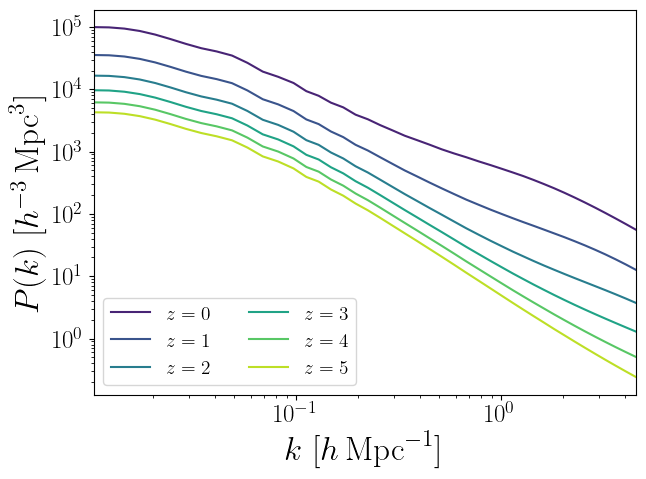

In [10]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
from matplotlib import pyplot as plt

for seed in [42]:

    # --- Initialize emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")

    # --- Load k-grid ---
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 1e-2) & (k_full < 4.9))[0][::6]
    k = k_full[k_idx]
    print (np.shape(k_idx))


    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)


    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    mnu = 0.0
    w = -1.0
    wa = 0.0

    cosmo_dict = {
        'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
        'mnu': mnu, 'w': w, 'wa': wa,
    }

    print(cosmo_dict)

    # --- Setup emulator inputs ---
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)



    def get_nonlinear_pk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k)
        pk_nl = pk_lin * boost[0]
        return pk_nl

    # --- Compute nonlinear P(k) ---
    pk_nl_z5 = get_nonlinear_pk(5.0)
    pk_nl_z0 = get_nonlinear_pk(0.0)

    # --- Print example values ---
    print("Nonlinear P(k) at z = 5:", pk_nl_z5[:5])
    print("Nonlinear P(k) at z = 0:", pk_nl_z0[:5])


    import jax
    import jax.numpy as jnp
    import numpy as np
    import equinox as eqx
    from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
    import os
    from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
    import euclidemu2 as ee2

    # --- Load k and emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 1e-2) & (k_full < 4.9))[0][::6]
    k = k_full[k_idx]
    k_shp = np.shape(k_idx)[0]

    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)
    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)

    cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
    print(cosmo_dict)
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)

    # --- Get nonlinear logP(k,z) ---
    def get_nl_logpk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k)
        pk_nl = pk_lin * boost[0]
        return jnp.log(pk_nl.astype(jnp.float32))

    # --- Background quantities ---
    G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

    def w_of_z(z):
        return jnp.polyval(w_coeffs, z)

    def Hz_func(z):
        a = 1.0 / (1.0 + z)
        w_z = w_of_z(z)
        Ez2 = Omm * (1 + z)**3 + (1 - Omm) * a**(-3.0 * (1.0 - 1.0))
        return 100.0 * h * jnp.sqrt(Ez2)

    def rho_m_func(z):
        Hz = Hz_func(z)
        rho_crit = 3 * Hz**2 / (8 * jnp.pi * G)
        return Omm * rho_crit

    # --- Load normalization ---
    data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
    norm_data = np.load(os.path.join(data_dir, "logpk_data.npz"))
    Hz_all = norm_data["Hz"]
    rho_m_all = norm_data["rho_m"]

    H_mean, H_std = Hz_all.mean(), Hz_all.std()
    log_rho_all = np.log10(rho_m_all + 1e-30)
    log_rho_mean, log_rho_std = log_rho_all.mean(), log_rho_all.std()

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

    # --- Define model class ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, rho, z):
            x = jnp.concatenate([P, H, rho, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- ODE RHS ---
    def rhs(z, logP, args):
        model, = args
        H_z = jnp.atleast_1d(H_norm(z))
        rho_z = jnp.atleast_1d(rho_norm(z))
        return model(logP, H_z, rho_z, z)

    # --- Initial condition and time range ---
    z0 = 5.0
    z1 = 0.0
    ts = jnp.linspace(z0, z1, 100)
    logpk0 = get_nl_logpk(z0)

    # --- Solve with all 10 models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
    all_pk = []

    for i in range(10):
        model_path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
        model = RHS()
        model_params = eqx.tree_deserialise_leaves(model_path, model)
        model = eqx.combine(model_params, model)

        term = ODETerm(rhs)
        solver = Tsit5()
        saveat = SaveAt(ts=ts)

        sol = diffeqsolve(
            term,
            solver,
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model,),
            saveat=saveat
        )
        logpk_sol = sol.ys
        all_pk.append(jnp.exp(logpk_sol))

    # --- Average prediction over models ---
    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

    print(f"Averaged nonlinear P(k) shape: {pk_mean.shape}")
    print(f"P(k, z=5): {pk_mean[0, :5]}")
    print(f"P(k, z=0): {pk_mean[30, :5]}")




    # Redshifts to plot
    z_list = [0, 1, 2, 3, 4, 5]
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(z_list)))

    plt.figure(figsize=(7, 5))

    # Plot all redshifts
    from matplotlib.lines import Line2D
    for i, z in enumerate(z_list):
        z_idx = int(jnp.argmin(jnp.abs(ts - z)))
        pk_pred = pk_mean[z_idx]
        pk_true = get_nonlinear_pk(z)

        # Plot Neural ODE prediction (solid)
        plt.plot(k, pk_pred, color=colors[i], ls='-', label=fr"$z={z}$")

        # Plot EuclidEmulator2 (dashed)
        #plt.plot(k, pk_true, color=colors[i], ls='--')

    # Axes settings
    import matplotlib as mpl
    from matplotlib import rcParams

    plt.rc('text', usetex=True)

    # Set global font sizes
    rcParams.update({
        "legend.fontsize": 18,         # Legend text
        "axes.labelsize": 24,          # Axis labels
        "xtick.labelsize": 18,         # X-axis tick labels
        "ytick.labelsize": 18          # Y-axis tick labels
    })
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$k\ [h\,\mathrm{Mpc}^{-1}]$")
    plt.ylabel(r"$P(k)\ [h^{-3}\,\mathrm{Mpc}^3]$")
    plt.xlim(k.min(), k.max())
    #plt.ylim(5e1, 3e5)

    # Custom legend


    plt.legend(fontsize=14, ncol=2, loc='lower left')

    #plt.tight_layout()
    plt.plot()
    plt.savefig('plots/pk_w_p.pdf')





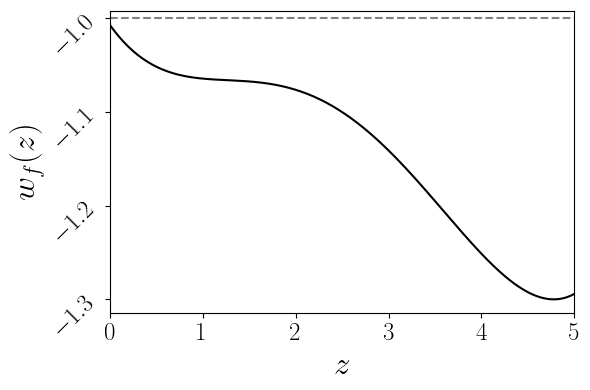

In [21]:

import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np  # Still needed for fitting coefficients

# Given w(z) data points
x1 = np.array([0, 1, 2, 3.5, 4.0, 4.5, 5])
y1 = np.array([-1.01, -1.05, -1.1, -1.15, -1.29,-1.29, -1.29])

# Fit degree-4 polynomial (still done with NumPy)
coeffs = np.polyfit(x1, y1, deg=4)
w_coeffs = jnp.array(coeffs)

# Plotting
z_plot = jnp.linspace(0, 5, 300)
w_plot = jnp.polyval(w_coeffs, z_plot)

plt.figure(figsize=(6, 4))
plt.plot(z_plot, w_plot, label=r"$w(z)$", color='k')
plt.axhline(y=-1, color='gray', ls='--', label=r"$w=-1$")

plt.xlim(0, 5)
plt.xlabel(r"$z$")
plt.ylabel(r"$w_f(z)$")
plt.tick_params(axis='y', labelrotation=45)

plt.tight_layout()
plt.savefig('plots/w_f.pdf')

(44,)
{'As': 2.319164838844771e-09, 'ns': 0.9551102751801642, 'Omb': 0.05717195839822765, 'Omm': 0.35157888464949827, 'h': 0.6213012817465179, 'mnu': 0.0, 'w': -1.29, 'wa': 0.0}
Nonlinear P(k) at z = 5: [4277.8926 4236.665  4047.0571 3710.4807 3260.1914]
Nonlinear P(k) at z = 0: [100386.68   99342.17   94847.11   86894.29   76241.086]
{'As': 2.319164838844771e-09, 'ns': 0.9551102751801642, 'Omb': 0.05717195839822765, 'Omm': 0.35157888464949827, 'h': 0.6213012817465179, 'mnu': 0.0, 'w': -1.29, 'wa': 0.0}
Averaged nonlinear P(k) shape: (100, 44)
P(k, z=5): [4277.892  4236.6655 4047.0564 3710.481  3260.1921]
P(k, z=0): [7628.375  7556.9307 7220.5024 6616.763  5812.879 ]


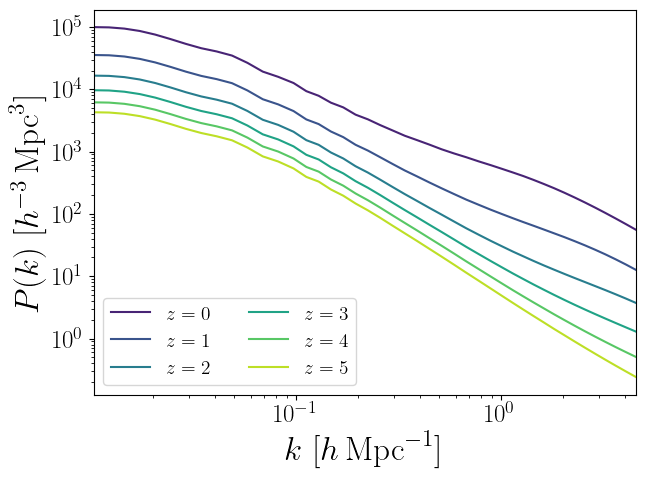

In [23]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
from matplotlib import pyplot as plt

for seed in [42]:

    # --- Initialize emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")

    # --- Load k-grid ---
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 1e-2) & (k_full < 4.9))[0][::6]
    k = k_full[k_idx]
    print (np.shape(k_idx))


    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)


    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    mnu = 0.0
    w = -1.29
    wa = 0.0

    cosmo_dict = {
        'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
        'mnu': mnu, 'w': w, 'wa': wa,
    }

    print(cosmo_dict)

    # --- Setup emulator inputs ---
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)



    def get_nonlinear_pk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k)
        pk_nl = pk_lin * boost[0]
        return pk_nl

    # --- Compute nonlinear P(k) ---
    pk_nl_z5 = get_nonlinear_pk(5.0)
    pk_nl_z0 = get_nonlinear_pk(0.0)

    # --- Print example values ---
    print("Nonlinear P(k) at z = 5:", pk_nl_z5[:5])
    print("Nonlinear P(k) at z = 0:", pk_nl_z0[:5])


    import jax
    import jax.numpy as jnp
    import numpy as np
    import equinox as eqx
    from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
    import os
    from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
    import euclidemu2 as ee2

    # --- Load k and emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 1e-2) & (k_full < 4.9))[0][::6]
    k = k_full[k_idx]
    k_shp = np.shape(k_idx)[0]

    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)
    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)

    cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': -1.29, 'wa': 0.0}
    print(cosmo_dict)
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)

    # --- Get nonlinear logP(k,z) ---
    def get_nl_logpk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]
        _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k)
        pk_nl = pk_lin * boost[0]
        return jnp.log(pk_nl.astype(jnp.float32))

    # --- Background quantities ---
    G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

    def w_of_z(z):
        return jnp.polyval(w_coeffs, z)

    def Hz_func(z):
        a = 1.0 / (1.0 + z)
        w_z = w_of_z(z)
        Ez2 = Omm * (1 + z)**3 + (1 - Omm) * a**(-3.0 * (1.0 - 1.0))
        return 100.0 * h * jnp.sqrt(Ez2)

    def rho_m_func(z):
        Hz = Hz_func(z)
        rho_crit = 3 * Hz**2 / (8 * jnp.pi * G)
        return Omm * rho_crit

    # --- Load normalization ---
    data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
    norm_data = np.load(os.path.join(data_dir, "logpk_data.npz"))
    Hz_all = norm_data["Hz"]
    rho_m_all = norm_data["rho_m"]

    H_mean, H_std = Hz_all.mean(), Hz_all.std()
    log_rho_all = np.log10(rho_m_all + 1e-30)
    log_rho_mean, log_rho_std = log_rho_all.mean(), log_rho_all.std()

    def H_norm(z):
        return (Hz_func(z) - H_mean) / H_std

    def rho_norm(z):
        return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

    # --- Define model class ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, rho, z):
            x = jnp.concatenate([P, H, rho, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- ODE RHS ---
    def rhs(z, logP, args):
        model, = args
        H_z = jnp.atleast_1d(H_norm(z))
        rho_z = jnp.atleast_1d(rho_norm(z))
        return model(logP, H_z, rho_z, z)

    # --- Initial condition and time range ---
    z0 = 5.0
    z1 = 0.0
    ts = jnp.linspace(z0, z1, 100)
    logpk0 = get_nl_logpk(z0)

    # --- Solve with all 10 models ---
    model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
    all_pk = []

    for i in range(10):
        model_path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
        model = RHS()
        model_params = eqx.tree_deserialise_leaves(model_path, model)
        model = eqx.combine(model_params, model)

        term = ODETerm(rhs)
        solver = Tsit5()
        saveat = SaveAt(ts=ts)

        sol = diffeqsolve(
            term,
            solver,
            t0=z0,
            t1=z1,
            dt0=-1e-2,
            y0=logpk0,
            args=(model,),
            saveat=saveat
        )
        logpk_sol = sol.ys
        all_pk.append(jnp.exp(logpk_sol))

    # --- Average prediction over models ---
    pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

    print(f"Averaged nonlinear P(k) shape: {pk_mean.shape}")
    print(f"P(k, z=5): {pk_mean[0, :5]}")
    print(f"P(k, z=0): {pk_mean[30, :5]}")




    # Redshifts to plot
    z_list = [0, 1, 2, 3, 4, 5]
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(z_list)))

    plt.figure(figsize=(7, 5))

    # Plot all redshifts
    from matplotlib.lines import Line2D
    for i, z in enumerate(z_list):
        z_idx = int(jnp.argmin(jnp.abs(ts - z)))
        pk_pred = pk_mean[z_idx]
        pk_true = get_nonlinear_pk(z)

        # Plot Neural ODE prediction (solid)
        plt.plot(k, pk_pred, color=colors[i], ls='-', label=fr"$z={z}$")

        # Plot EuclidEmulator2 (dashed)
        #plt.plot(k, pk_true, color=colors[i], ls='--')

    # Axes settings
    import matplotlib as mpl
    from matplotlib import rcParams

    plt.rc('text', usetex=True)

    # Set global font sizes
    rcParams.update({
        "legend.fontsize": 18,         # Legend text
        "axes.labelsize": 24,          # Axis labels
        "xtick.labelsize": 18,         # X-axis tick labels
        "ytick.labelsize": 18          # Y-axis tick labels
    })
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$k\ [h\,\mathrm{Mpc}^{-1}]$")
    plt.ylabel(r"$P(k)\ [h^{-3}\,\mathrm{Mpc}^3]$")
    plt.xlim(k.min(), k.max())
    #plt.ylim(5e1, 3e5)

    # Custom legend


    plt.legend(fontsize=14, ncol=2, loc='lower left')

    #plt.tight_layout()
    plt.plot()
    plt.savefig('plots/pk_w_f.pdf')





In [ ]:
# debug

(44,)
{'As': 2.1585045255580046e-09, 'ns': 0.9622792916136162, 'Omb': 0.05527300479603852, 'Omm': 0.36987084272153714, 'h': 0.6712274626240868, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}


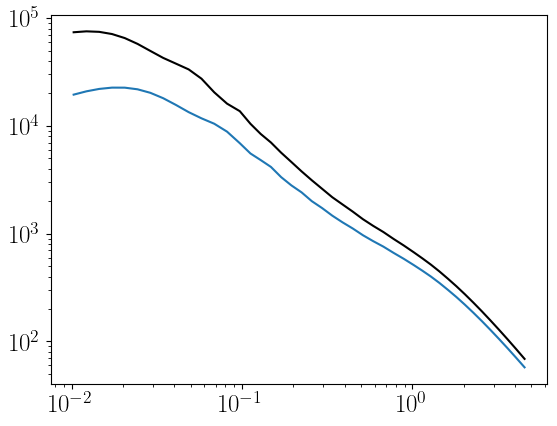

In [ ]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
from matplotlib import pyplot as plt
import camb

for seed in [45]:

    # --- Initialize emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")

    # --- Load k-grid ---
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 1e-2) & (k_full < 4.9))[0][::6]
    k = k_full[k_idx]
    print (np.shape(k_idx))


    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)


    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    mnu = 0.0
    w = -1.0
    wa = 0.

    cosmo_dict = {
        'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
        'mnu': mnu, 'w': w, 'wa': wa,
    }

    print(cosmo_dict)

    # --- Setup emulator inputs ---
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)



    def get_linear_pk_camb(k, z):
        H0 = cosmo_dict["h"] * 100
        pars = camb.CAMBparams()
        pars.set_cosmology(
            H0=H0,
            ombh2=omega_b,
            omch2=omega_cdm,
            mnu=cosmo_dict["mnu"],
        )
        #pars.set_dark_energy(w=cosmo_dict["w"], wa=cosmo_dict["wa"] ,dark_energy_model='ppf')
        pars.InitPower.set_params(As=cosmo_dict["As"], ns=cosmo_dict["ns"])
        pars.set_matter_power(redshifts=[z], kmax=k.max())
        results = camb.get_results(pars)
        PK = results.get_matter_power_interpolator(hubble_units=False,k_hunit=False,)
        pk_lin = PK.P(z, k)  

        return pk_lin

    # --- Compute nonlinear P(k) ---
    pk_nl_z5_camb = get_nonlinear_pk_camb(5.0)
    pk_nl_z0_camb = get_nonlinear_pk_camb(0.0)

    def get_linear_pk(z):
        inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
        pk_lin = emulator.predict(inp)[k_idx]

        return pk_lin

    pk_nl_z5 = get_nonlinear_pk(5.0)
    pk_nl_z0 = get_nonlinear_pk(0.0)

    plt.plot(k, pk_nl_z0, color ='k')
    plt.plot(k, pk_nl_z0_camb ) # division by h^3 to get the units right
    plt.xscale('log')
    plt.yscale('log')


    

(44,)
{'As': 2.1585045255580046e-09, 'ns': 0.9622792916136162, 'Omb': 0.05527300479603852, 'Omm': 0.36987084272153714, 'h': 0.6712274626240868, 'mnu': 0.0, 'w': -0.8, 'wa': 0.0}


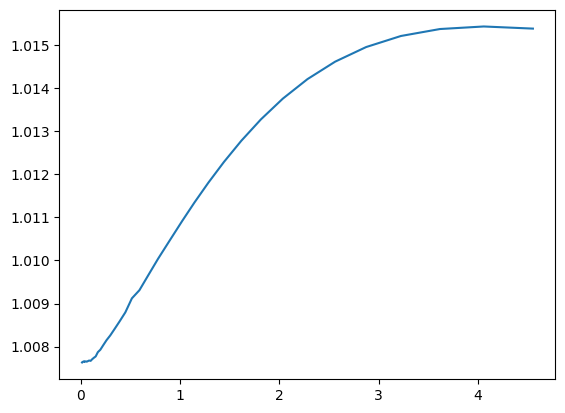

In [8]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
from matplotlib import pyplot as plt
import camb

for seed in [45]:

    # --- Initialize emulator ---
    emulator = CosmoPowerJAX(probe="mpk_lin")

    # --- Load k-grid ---
    k_full = emulator.modes.astype(np.float32)
    k_idx = np.where((k_full > 1e-2) & (k_full < 4.9))[0][::6]
    k = k_full[k_idx]
    print (np.shape(k_idx))


    # --- Random cosmology ---
    rng = np.random.default_rng(seed=seed)


    As = rng.uniform(1.7e-9, 2.5e-9)
    ns = rng.uniform(0.92, 1.00)
    Omb = rng.uniform(0.04, 0.06)
    Omm = rng.uniform(0.24, 0.40)
    h = rng.uniform(0.61, 0.73)
    mnu = 0.0
    w = -0.8
    wa = 0.

    cosmo_dict = {
        'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
        'mnu': mnu, 'w': w, 'wa': wa,
    }

    print(cosmo_dict)

    # --- Setup emulator inputs ---
    omega_b = Omb * h**2
    omega_cdm = (Omm - Omb) * h**2
    ln_10_A_s = np.log(1e10 * As)



    def get_linear_pk_camb(k, z):
        H0 = cosmo_dict["h"] * 100
        pars = camb.CAMBparams()
        pars.set_cosmology(
            H0=H0,
            ombh2=omega_b,
            omch2=omega_cdm,
            mnu=cosmo_dict["mnu"],
        )
        #pars.set_dark_energy(w=cosmo_dict["w"], wa=cosmo_dict["wa"] ,dark_energy_model='ppf')
        pars.InitPower.set_params(As=cosmo_dict["As"], ns=cosmo_dict["ns"])
        pars.set_matter_power(redshifts=[z], kmax=k.max())
        results = camb.get_results(pars)
        PK = results.get_matter_power_interpolator(hubble_units=False,k_hunit=False,)
        pk_lin = PK.P(z, k)  

        return pk_lin

    def get_linear_pk_camb_w(k, z):
        H0 = cosmo_dict["h"] * 100
        pars = camb.CAMBparams()
        pars.set_cosmology(
            H0=H0,
            ombh2=omega_b,
            omch2=omega_cdm,
            mnu=cosmo_dict["mnu"],
        )
        pars.set_dark_energy(w=cosmo_dict["w"], wa=cosmo_dict["wa"] ,dark_energy_model='ppf')
        pars.InitPower.set_params(As=cosmo_dict["As"], ns=cosmo_dict["ns"])
        pars.set_matter_power(redshifts=[z], kmax=k.max())
        results = camb.get_results(pars)
        PK = results.get_matter_power_interpolator(hubble_units=False,k_hunit=False,)
        pk_lin = PK.P(z, k)  

        return pk_lin
    
    z=5

    plt.plot(k,get_linear_pk_camb(k, z) / get_linear_pk_camb_w(k, z))
    #plt.plot(k,get_linear_pk_camb_w(k, z))
    #plt.xscale('log')
    #plt.yscale('log')
    
    



    